In [27]:
import sys
print(sys.executable)

/Users/tangnade/miniconda3/envs/new_env/bin/python


In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/fin-quiz'): #walk means to go through all the directories and subdirectories
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import os


from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#warnings.filterwarnings('ignore')

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)
set_config(transform_output = 'pandas')
pd.options.mode.chained_assignment = None

In [30]:
train = pd.read_csv(r'train.csv').drop(['row_id', 'time_id'], axis = 1)

In [31]:
train.tail(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184
5237979,199,480,540,1884285.71,-1,1.002129,24073677.32,1.000859,1.001494,1.002129,250081.44,1.002447,300167.56,1.002274,-6.530285


### 1. Train the model without scaling ###



In [32]:
# split the dataset into features and target 
X = train[~train.target.isna()] #this means that we are taking all the rows where target is not null
y = X.pop('target') #the way target value computed is 

**正态分布标准化**

𝑥′=(𝑥−𝑚𝑢)𝜎

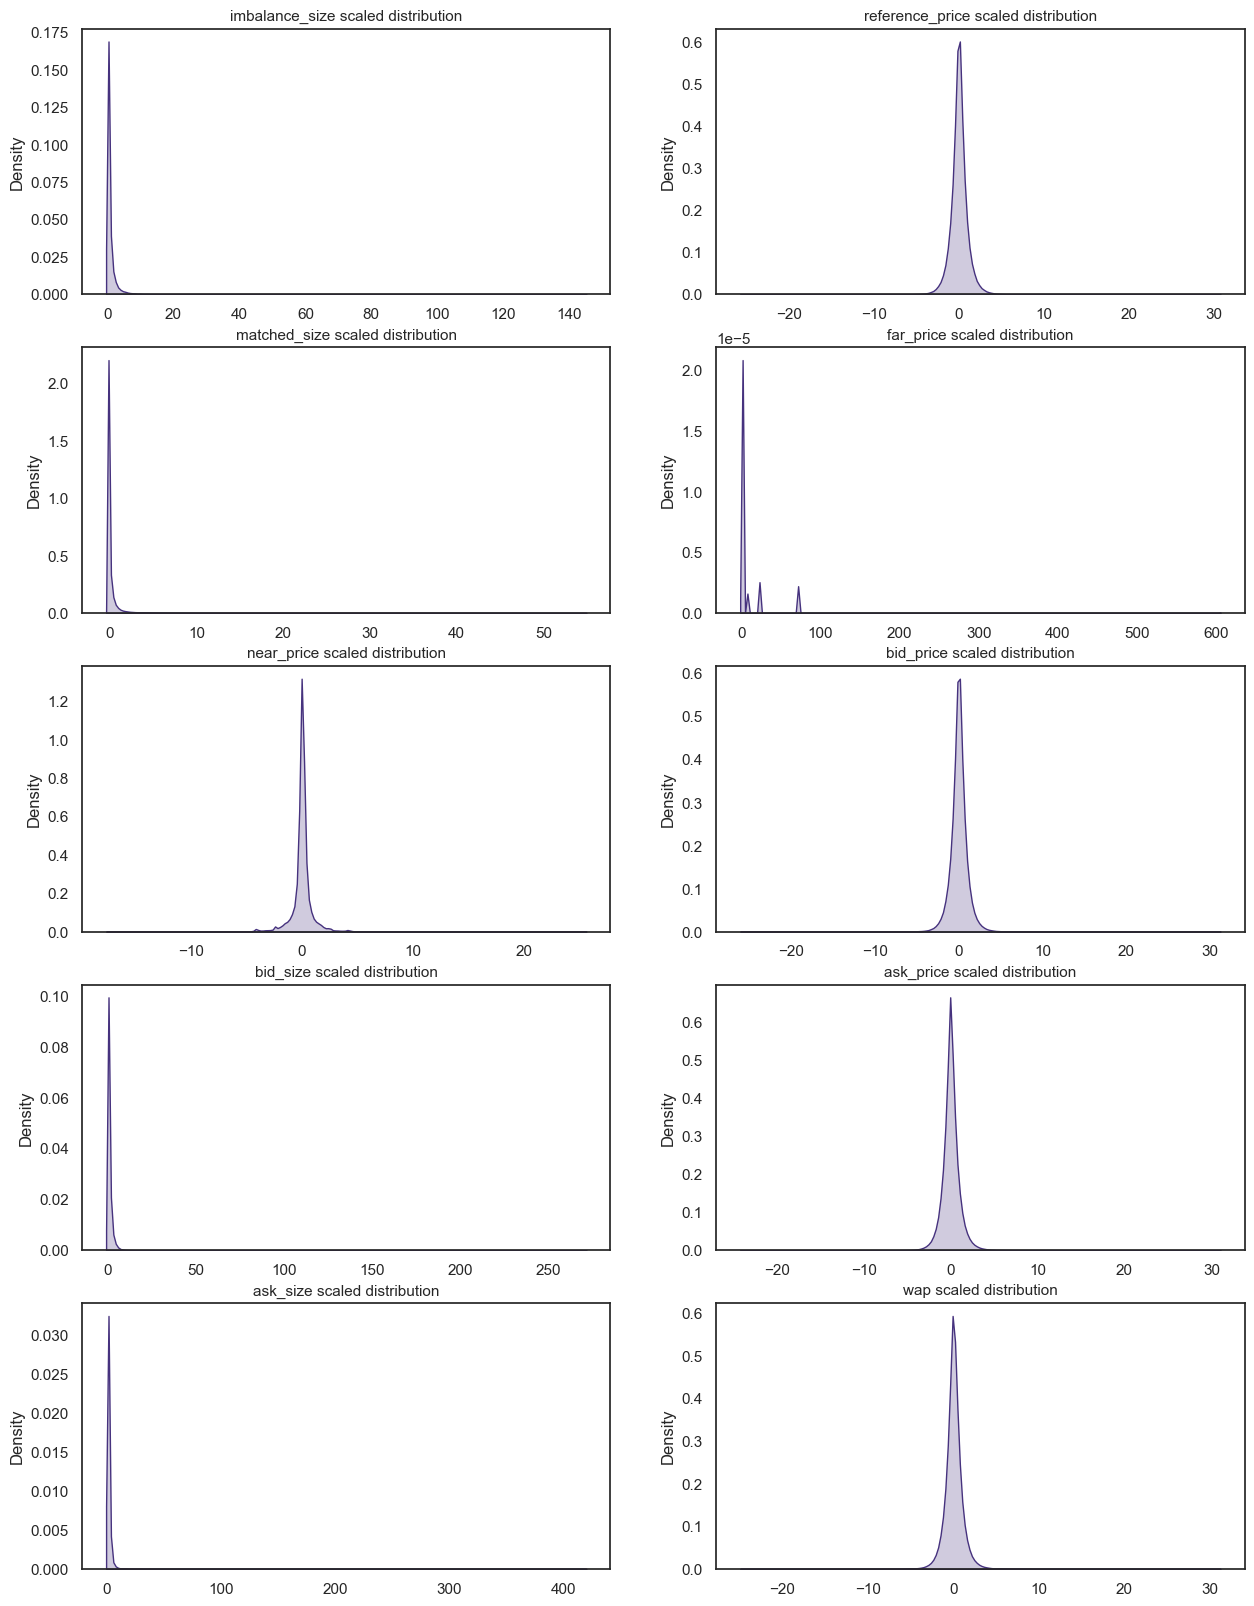

In [33]:
# scale the data using StandardScaler for the far_price
scaler = StandardScaler() # this scale the data by removing the mean and scaling to unit variance
train_scaled = scaler.fit_transform(train)#transform the data to standard normal distribution

num_features = [ 'imbalance_size','reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap']


# plot the scaled datset
fig, axes = plt.subplots(5,2, figsize = (15,20))#fig receives the figure object and axes receives the axes object

axes = axes.flatten()

for i, feature in enumerate(num_features):
    
    sns.kdeplot(train_scaled[feature], ax = axes[i], fill = True)#kdeplot is a function that plots the kernel density estimate
    axes[i].set_title(f'{feature} scaled distribution', size = 11)
    axes[i].set_xlabel(None)

In [34]:
# split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 700)
#random_state is the seed used by the random number generator,which is used to shuffle the data before applying the split 

**1.1 不做缩放**

In [35]:
# train the XGBoost model 
xgb = XGBRegressor(random_state = 700) #XGBRegressor could receive a lot of parameters, but we are using the default ones
xgb.fit(X_train, y_train)


# prediction on the validation set
xgb_pred_no = xgb.predict(X_val)


# calculate the mae for the model on the validation set
xgb_no_mae = mean_absolute_error(y_val, xgb_pred_no)


# print the result
print('MAE of XGBoost without scaling: ', xgb_no_mae)

MAE of XGBoost without scaling:  6.276798721722445


**1.2 所有特征做缩放**

In [36]:
# scale the dataset using scaler
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
#fit_transform and transform are methods of the scaler object,the former is used to fit the scaler to the data and then transform it, the latter is used to transform the data without fitting it
#and fit is standard_scaler()
Y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
Y_val_scaled = scaler.transform(y_val.values.reshape(-1,1))

# fit the XGBoost model to the scaled training data
xgb_scaled = XGBRegressor(random_state = 700)#randowm_state range is from 0 to 2^32-1,you could use any number you want,but the bigger the number is,the more time it takes to run the code
xgb_scaled.fit(X_train_scaled, Y_train_scaled)


# Make prediction on the scaled validation set
xgb_pred_scaled = xgb_scaled.predict(X_val_scaled)


# calculate the mae for the model on the validation set
xgb_scaled_mae = mean_absolute_error(Y_val_scaled, xgb_pred_scaled)


# print the result
print('MAE of XGBoost with scaling: ', xgb_scaled_mae)

MAE of XGBoost with scaling:  0.6645427351919224


**1.3 只对far_price做缩放**

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

standard_transformer = Pipeline(steps=[ #Pipeline is a class that allows to chain multiple estimators into one,chain mulltiple estimators means 
        ('standard', StandardScaler())])


preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough all the other features except far_price
        transformers=[
            ('std', standard_transformer , ['far_price']),
            #('mm', minmax_transformer , ['x','y'])
        ])

X_train_far = preprocessor.fit_transform(X_train)
X_train_far

,std__far_price,remainder__stock_id,remainder__date_id,remainder__seconds_in_bucket,remainder__imbalance_size,remainder__imbalance_buy_sell_flag,remainder__reference_price,remainder__matched_size,remainder__near_price,remainder__bid_price,remainder__bid_size,remainder__ask_price,remainder__ask_size,remainder__wap
2545350,-0.000015,65,235,500,2050251.81,-1,1.002837,2.925583e+07,1.002386,1.002837,197935.52,1.003063,146485.71,1.002967
1458831,NaN,119,136,70,432688.58,-1,1.000466,1.009347e+07,NaN,0.999246,39681.01,1.000727,15160.86,1.000318
3142387,NaN,103,290,250,1031736.20,-1,1.002009,7.442018e+06,NaN,1.001517,1141.77,1.002561,1796.08,1.001923
4923043,NaN,63,452,200,0.00,0,0.998938,2.608632e+06,NaN,0.998938,14832.66,0.999119,10974.85,0.999042
550431,-0.006362,75,51,540,1206225.52,-1,0.999196,1.811702e+07,0.998284,0.999196,46008.00,0.999457,154934.00,0.999256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720797,NaN,130,160,170,0.00,0,0.997592,8.618088e+07,NaN,0.997592,18456.90,0.997706,61881.60,0.997618
3472550,NaN,143,320,270,102211.85,1,1.000672,2.549742e+05,NaN,0.998052,66568.32,1.000672,224425.00,0.998653
3668891,NaN,111,338,190,187393.08,-1,1.001596,1.903090e+06,NaN,1.001596,44440.33,1.002040,15806.00,1.001923
3691935,NaN,155,340,240,960353.86,1,0.999352,1.246833e+06,NaN,0.999033,28375.92,0.999459,28200.00,0.999247


In [39]:
X_val_far = preprocessor.fit_transform(X_val)
X_val_far

,std__far_price,remainder__stock_id,remainder__date_id,remainder__seconds_in_bucket,remainder__imbalance_size,remainder__imbalance_buy_sell_flag,remainder__reference_price,remainder__matched_size,remainder__near_price,remainder__bid_price,remainder__bid_size,remainder__ask_price,remainder__ask_size,remainder__wap
3722146,NaN,166,343,100,17052934.87,1,0.999319,20463296.97,NaN,0.999070,103309.00,0.999319,84995.34,0.999207
148175,NaN,178,14,20,20935375.44,1,0.999152,31934047.51,NaN,0.998975,25307.25,0.999152,1687.45,0.999141
293839,0.015305,110,27,460,8507033.20,1,0.999517,33733052.37,1.006352,0.999365,42371.98,0.999517,55802.64,0.999431
224630,NaN,18,21,160,1044289.87,1,0.998353,12374659.19,NaN,0.998199,114169.86,0.998353,40228.81,0.998313
1276824,NaN,141,119,180,18936142.68,-1,0.993152,68877105.85,NaN,0.993299,7713.81,0.993592,27074.00,0.993364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203487,NaN,52,296,20,1368233.59,-1,0.999052,2768518.51,NaN,0.999052,13930.56,0.999465,23904.66,0.999204
1280675,-0.000175,49,119,380,1242086.53,1,0.996847,21978852.34,1.001056,0.996625,50737.44,0.996847,158904.68,0.996679
4595636,0.000656,56,422,330,0.00,0,1.001597,22509153.54,1.001597,1.001597,15001.50,1.002084,19840.40,1.001807
4200911,-0.005674,131,386,390,265149.34,-1,1.000316,21542690.70,0.999116,1.000252,30031.96,1.000379,65222.75,1.000292


In [40]:
# fit the XGBoost model to the scaled training data
xgb_scaled_far = XGBRegressor(random_state = 700)
xgb_scaled_far.fit(X_train_far, y_train)


# Make prediction on the scaled validation set
xgb_pred_far = xgb_scaled_far.predict(X_val_far)


# calculate the mae for the model on the validation set
xgb_far_mae = mean_absolute_error(y_val, xgb_pred_far)


# print the result
print('MAE of XGBoost with scaling only far_price: ', xgb_far_mae)

MAE of XGBoost with scaling only far_price:  6.278171222344928


## 2.使用不同的booster训练XGBoost ##

In [41]:
# Fit an XGBoost model with a linear booster to the training data
xgb_model = XGBRegressor(booster='gblinear', random_state=700)
xgb_model.fit(X_train, y_train)

# Make predictions on the validation set
xgb_predictions = xgb_model.predict(X_val)

# Calculate the root mean squared error of the model on the validation set
#root MSE means the squarde root of the mean squared error
xgb_mae = mean_absolute_error(y_val, xgb_predictions)

# Print the root mean squared error of the model on the validation set
print("RMSE of XGBoost model with a linear booster:", xgb_mae)


#############################################################################################

# Scale the data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
Y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
Y_val_scaled = scaler.transform(y_val.values.reshape(-1,1))

# Fit an XGBoost model with a linear booster to the scaled training data
xgb_model_scaled = XGBRegressor(booster='gblinear', random_state=700)
xgb_model_scaled.fit(X_train_scaled, Y_train_scaled)

# Make predictions on the scaled validation set
xgb_predictions_scaled = xgb_model_scaled.predict(X_val_scaled)

# Calculate the root mean squared error of the model on the scaled validation set
xgb_rmse_scaled = mean_absolute_error(Y_val_scaled, xgb_predictions_scaled)

# Print the root mean squared error of the model on the scaled validation set
print("RMSE of XGBoost model with a linear booster and scaling:", xgb_rmse_scaled)



RMSE of XGBoost model with a linear booster: 6.408276174361427
RMSE of XGBoost model with a linear booster and scaling: 0.6733052226805754


## 3.使用标准缩放器做交叉验证 ##

In [18]:
train = pd.read_csv(r'train.csv').drop(['row_id', 'time_id'], axis = 1)

In [19]:
X = train[~train.target.isna()]
y = X.pop('target')

In [20]:
from sklearn.model_selection import KFold

In [21]:
K_fold = KFold(n_splits = 5, shuffle = True, random_state = 700) #Kfolds helps to k

for train_idx, val_idx in K_fold.split(X):
    print((len(train_idx), len(val_idx)))

(4190313, 1047579)
(4190313, 1047579)
(4190314, 1047578)
(4190314, 1047578)
(4190314, 1047578)


In [22]:
xgb_1 = []

for fold, (train_idx, val_idx) in enumerate(K_fold.split(X)):
    # train set
    x_t = X.iloc[train_idx]
    y_t = y.iloc[train_idx]
    
    # valid set
    x_val = X.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    
    xgb = XGBRegressor(random_state = 700)
    xgb.fit(x_t, y_t)

    # prediction on the validation set
    xgb_pred_no = xgb.predict(x_val)


    # calculate the mae for the model on the validation set
    xgb_no_mae = mean_absolute_error(y_val, xgb_pred_no)


    # append the result
    xgb_1.append(xgb_no_mae)

In [23]:
print('Mean MAE of with no scale dataset: ', np.mean(xgb_1))
print('**************************************************************')
print('Variance MAE of with no scale dataset: ', np.var(xgb_1))

Mean MAE of with no scale dataset:  6.269043547684512
**************************************************************
Variance MAE of with no scale dataset:  4.641012976045008e-05


**3.2 缩放**

In [24]:
xgb_2 = []

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

for fold, (train_idx, val_idx) in enumerate(K_fold.split(X_train_scaled)):
    # train set
    x_t = X_train_scaled.iloc[train_idx]
    y_t = y.iloc[train_idx]
    
    # valid set
    x_val = X_train_scaled.iloc[val_idx]
    y_val = y.iloc[val_idx]
    
    
    xgb = XGBRegressor(random_state = 700)
    xgb.fit(x_t, y_t)


    # prediction on the validation set
    xgb_pred_no = xgb.predict(x_val)

    # calculate the mae for the model on the validation set
    xgb_no_mae = mean_absolute_error(y_val, xgb_pred_no)


    # append the result
    xgb_2.append(xgb_no_mae)

In [25]:
print('Mean MAE of with the scaled dataset: ', np.mean(xgb_2))
print('**************************************************************')
print('Variance MAE of with the scaled dataset: ', np.var(xgb_2))

Mean MAE of with the scaled dataset:  6.2689176754627915
**************************************************************
Variance MAE of with the scaled dataset:  3.2061560584086025e-05


### 4.使用LSTM改进预测 ###

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [42]:
from keras.optimizers import SGD
from keras.initializers import he_uniform
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.regularizers import l1
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras import backend as K


# 读取数据
data = pd.read_csv('train.csv')
data = data.fillna(0)
# 选择特征和目标变量
features = ['far_price','reference_price','imbalance_buy_sell_flag','imbalance_size', 'matched_size', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap']
target = 'target'

X = data[features]
y = data[target]

# 数据预处理
#scaler = MinMaxScaler(feature_range=(0, 1))
#X = scaler.fit_transform(X)

# 定义一个RMSE评估函数
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=700)

#处理空值和无穷大的值
# 使用np.nan_to_num替换NaN值为0
X_train = np.nan_to_num(X_train)

# 使用np.isinf找到无穷大的值并替换为最大值
X_train[np.isinf(X_train)] = np.finfo(X_train.dtype).max

# 使用np.nan_to_num替换NaN值为0
X_test = np.nan_to_num(X_test)

# 使用np.isinf找到无穷大的值并替换为最大值
X_test[np.isinf(X_test)] = np.finfo(X_test.dtype).max

x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_test = x_scaler.transform(X_test)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test = y_scaler.transform(y_test.values.reshape(-1,1))

# 重塑输入数据为3D数组，形状为[样本数, 时间步长, 特征数]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# 构建LSTM模型
model = Sequential()
model.add(LSTM(20, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer=he_uniform(seed=1)))
model.add(Dropout(0.2))  # 添加Dropout层，丢弃率为0.2
model.add(Dense(1, kernel_initializer=he_uniform(seed=1), activity_regularizer=l1(0.001)))  # 在Dense层中添加L1正则化，正则化参数为0.001
model.add(LeakyReLU(alpha=0.1))


# 创建一个优化器实例，设置学习率
optimizer = SGD(learning_rate=0.1)

# 在模型编译时使用这个优化器,并使用rmse做损失
#model.compile(loss='mse', optimizer=optimizer, metrics=['rmse'])

# 在模型编译时使用这个优化器，并使用MAE作为损失函数，RMSE作为评估指标
model.compile(loss='mae', optimizer=optimizer, metrics=[rmse])

#再使用MAE作为评价指标
#model.compile(loss='mae', optimizer=optimizer)

# 训练模型
history = model.fit(X_train, y_train, epochs=20, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# 评估模型在测试集上的性能
test_loss, test_rmse = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', test_loss)
print('Test RMSE:', test_rmse)

Epoch 1/20
50925/50925 - 98s - loss: 0.6756 - rmse: 0.9751 - val_loss: 0.6725 - val_rmse: 0.9712 - 98s/epoch - 2ms/step
Epoch 2/20
50925/50925 - 95s - loss: 0.6733 - rmse: 0.9718 - val_loss: 0.6716 - val_rmse: 0.9700 - 95s/epoch - 2ms/step
Epoch 3/20
50925/50925 - 97s - loss: 0.6726 - rmse: 0.9710 - val_loss: 0.6712 - val_rmse: 0.9695 - 97s/epoch - 2ms/step
Epoch 4/20
50925/50925 - 101s - loss: 0.6723 - rmse: 0.9705 - val_loss: 0.6713 - val_rmse: 0.9697 - 101s/epoch - 2ms/step
Epoch 5/20
50925/50925 - 95s - loss: 0.6720 - rmse: 0.9702 - val_loss: 0.6707 - val_rmse: 0.9689 - 95s/epoch - 2ms/step
Epoch 6/20
50925/50925 - 102s - loss: 0.6718 - rmse: 0.9699 - val_loss: 0.6704 - val_rmse: 0.9685 - 102s/epoch - 2ms/step
Epoch 7/20
50925/50925 - 95s - loss: 0.6717 - rmse: 0.9697 - val_loss: 0.6702 - val_rmse: 0.9682 - 95s/epoch - 2ms/step
Epoch 8/20
50925/50925 - 96s - loss: 0.6715 - rmse: 0.9695 - val_loss: 0.6702 - val_rmse: 0.9681 - 96s/epoch - 2ms/step
Epoch 9/20
50925/50925 - 96s - loss:

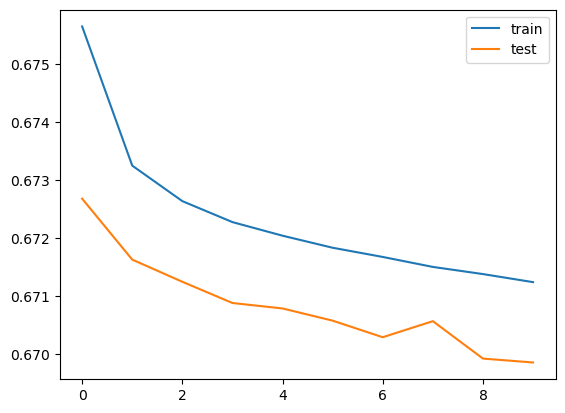

In [26]:
import matplotlib.pyplot as plt
# 绘制训练损失和验证损失
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()